In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import imageio

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # density estimation
        self.block2 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1),
        )
        # color estimation
        self.block3 = nn.Sequential(
            nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Linear(hidden_dim // 2, 3),
            nn.Sigmoid(),
        )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2**j * x))
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(
            o, self.embedding_dim_pos
        )  # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(
            d, self.embedding_dim_direction
        )  # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x)  # h: [batch_size, hidden_dim]
        tmp = self.block2(
            torch.cat((h, emb_x), dim=1)
        )  # tmp: [batch_size, hidden_dim + 1]
        h, sigma = (
            tmp[:, :-1],
            self.relu(tmp[:, -1]),
        )  # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(
            torch.cat((h, emb_d), dim=1)
        )  # h: [batch_size, hidden_dim // 2]
        c = self.block4(h)  # c: [batch_size, 3]
        return c, sigma

In [5]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], axis=-1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], axis=-1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103
(100, 100, 3) (100, 100, 3)


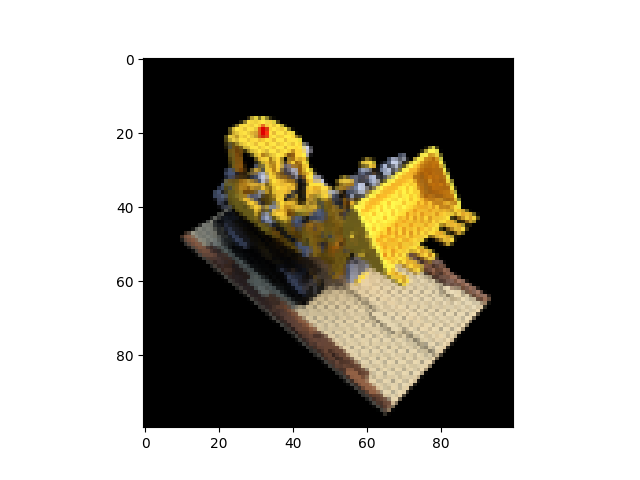

In [6]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
test_images = images[101:,:, :,:3]
test_poses = poses[101:]
images = images[:100,:, :,:3]
poses = poses[:100]
rays_o, rays_d = get_rays(H, W, focal, testpose)
print(rays_o.shape, rays_d.shape)

training_dataset = np.zeros((images.shape[0] * H * W, 9))
for i in range(images.shape[0] - 1):
    curr_data = np.zeros((H * W, 9))
    rays_o, rays_d = get_rays(H, W, focal, poses[i])
    curr_data[:, :3] = rays_o.reshape(-1, 3)
    curr_data[:, 3:6] = rays_d.reshape(-1, 3)
    curr_data[:, 6:9] = images[i].reshape(-1, 3)
    training_dataset[i * H * W : (i + 1) * H * W] = curr_data

testing_dataset = np.zeros((test_images.shape[0] * H * W, 9))
for i in range(test_images.shape[0] - 1):
    curr_data = np.zeros((H * W, 9))
    rays_o, rays_d = get_rays(H, W, focal, test_poses[i])
    curr_data[:, :3] = rays_o.reshape(-1, 3)
    curr_data[:, 3:6] = rays_d.reshape(-1, 3)
    curr_data[:, 6:9] = test_images[i].reshape(-1, 3)
    testing_dataset[i * H * W : (i + 1) * H * W] = curr_data

# training_dataset = torch.from_numpy(training_dataset).float().to(device)
# testing_dataset = torch.from_numpy(testing_dataset).float().to(device)

training_dataset = torch.from_numpy(
        np.load("./training_data.npz", allow_pickle=True)["data"]
    ).float()
testing_dataset = torch.from_numpy(
    np.load("./training_data.npz", allow_pickle=True)["data"]
).float()

plt.imshow(testimg)
plt.show()

In [7]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat(
        (
            torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
            accumulated_transmittance[:, :-1],
        ),
        dim=-1,
    )


def render_rays(nerf_model, ray_origins, ray_directions, hn=2, hf=6, nb_bins=192):
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(
        ray_origins.shape[0], nb_bins
    )
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.0
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat(
        (
            t[:, 1:] - t[:, :-1],
            torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1),
        ),
        -1,
    )

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(
        1
    )  # [batch_size, nb_bins, 3]
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(
        nb_bins, ray_directions.shape[0], 3
    ).transpose(0, 1)

    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)
    sigma = sigma.reshape(x.shape[:-1])

    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(
        2
    ) * alpha.unsqueeze(2)
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

In [8]:
def test(model, hn, hf, dataset, epoch, chunk_size=10, img_index=0, nb_bins=64, H=100, W=100, save_img=False):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """
    with torch.no_grad():
        ray_origins = dataset[img_index * H * W : (img_index + 1) * H * W, :3]
        ray_directions = dataset[img_index * H * W : (img_index + 1) * H * W, 3:6]
        ground_truth_px_values = dataset[img_index * H * W : (img_index + 1) * H * W, 6:]

        data = []  # list of regenerated pixel values
        img_loss = 0
        for i in range(int(np.ceil(H / chunk_size))):  # iterate over chunks
            # Get chunk of rays
            ray_origins_ = ray_origins[i * W * chunk_size : (i + 1) * W * chunk_size].to(
                device
            )
            ray_directions_ = ray_directions[
                i * W * chunk_size : (i + 1) * W * chunk_size
            ].to(device)
            ground_truth_px_values_ = ground_truth_px_values[
                i * W * chunk_size : (i + 1) * W * chunk_size
            ].to(device)
            regenerated_px_values = render_rays(
                model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins
            )
            data.append(regenerated_px_values)
            img_loss += ((ground_truth_px_values_ - regenerated_px_values) ** 2).sum()
        img_loss /= int(np.ceil(H / chunk_size))
        img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

        if save_img:
            os.makedirs("./novel_views", exist_ok=True)
            plt.figure()
            plt.imshow(img)
            plt.savefig(
                f"./novel_views/img_epoch_{epoch}_idx_{img_index}.png", bbox_inches="tight"
            )
            plt.close()
        return img_loss, img

In [9]:
def train(
    nerf_model,
    optimizer,
    scheduler,
    data_loader,
    fig,ax,
    device="cpu",
    hn=0,
    hf=1,
    nb_epochs=int(1e5),
    nb_bins=192,
    H=100,
    W=100,
):
    os.makedirs("./novel_views", exist_ok=True)
    training_loss = []
    log_interval = 100
    curr_step = 0
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # plt.show(block=False)
    for epoch in tqdm(range(nb_epochs)):
        pbar = tqdm(data_loader)
        for batch_idx, batch in enumerate(pbar):
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)

            regenerated_px_values = render_rays(
                nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins
            )
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            curr_step += 1
            if batch_idx % log_interval == 0:
                # print(f"Step: {batch_idx}, Loss: {loss.item()}")
                pbar.set_description(f"Step: {batch_idx}, Loss: {loss.item()}")
                _, test_img = test(
                    nerf_model,
                    hn,
                    hf,
                    testing_dataset,
                    epoch,
                    chunk_size=20,
                    img_index=0,
                    nb_bins=nb_bins,
                    H=H,
                    W=W,
                )
                # Plot the training loss
                ax[0].clear()
                ax[0].plot(training_loss, label="Training Loss")
                ax[0].set_yscale("log")
                ax[0].set_xlabel("Step")
                ax[0].set_ylabel("Loss")
                ax[1].imshow(test_img)
                ax[1].set_title("Test Image")
                fig.canvas.draw()
                # fig.canvas.flush_events()

        scheduler.step()
        test_loss = 0
        with imageio.get_writer(
            f"./novel_views/testing_epoch_{epoch}.gif", mode="I"
        ) as writer:
            for img_index in tqdm(range(testing_dataset.shape[0])):
                test_img_loss, _ = test(
                    nerf_model,
                    hn,
                    hf,
                    testing_dataset,
                    epoch,
                    chunk_size=20,
                    img_index=img_index,
                    nb_bins=nb_bins,
                    H=H,
                    W=W,
                    save_img=True,
                )
                writer.append_data(
                    imageio.imread(
                        f"./novel_views/img_epoch_{epoch}_idx_{img_index}.png"
                    )
                )
                test_loss += test_img_loss
        test_loss /= 200
        test_loss = test_loss.item()
        print(f"--- Epoch: {epoch}, Test Loss: {test_loss}")
        ax.plot(
            [batch_idx + epoch * len(data_loader)] * 2,
            [test_loss, test_loss],
            label="Test Loss",
        )
        ax.legend()
        fig.canvas.draw()
    fig.savefig("./training_loss.png")
    plt.close(fig)

    return training_loss

In [10]:
model = NerfModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    model_optimizer, milestones=[2, 4, 8], gamma=0.5
)
data_loader = DataLoader(
    training_dataset, batch_size=128, shuffle=True, num_workers=4
)

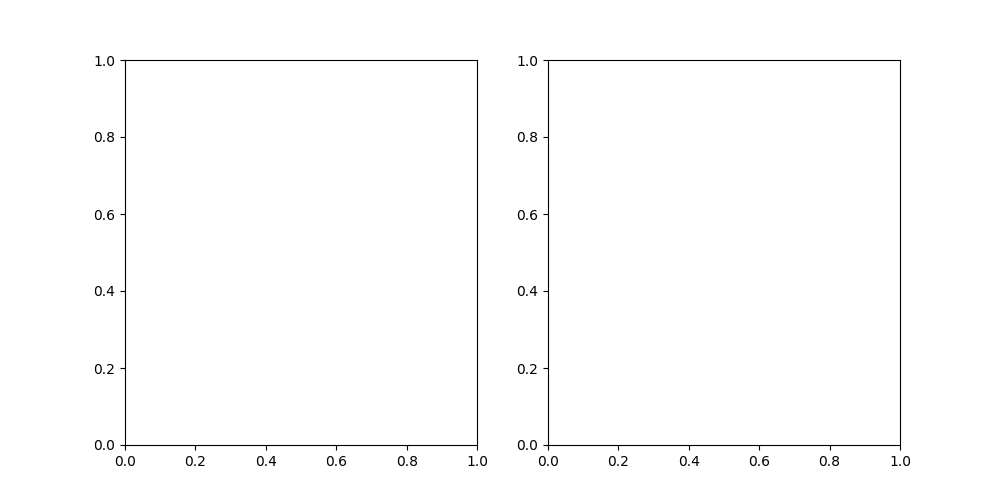

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.show()

In [12]:
train(
    model,
    model_optimizer,
    scheduler,
    data_loader,
    fig,ax,    
    nb_epochs=16,
    device=device,
    hn=2,
    hf=6,
    nb_bins=64,
    H=100,
    W=100,
)

  0%|          | 0/16 [00:00<?, ?it/s]

Step: 0, Loss: 303.9334716796875
Step: 100, Loss: 27.533374786376953
Step: 200, Loss: 9.896552085876465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.5856464].


Step: 300, Loss: 4.774402141571045
Step: 400, Loss: 5.938909530639648
Step: 500, Loss: 5.585391998291016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.68567824].


Step: 600, Loss: 3.0570881366729736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.6553245].


Step: 700, Loss: 2.5429091453552246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.5776355].


Step: 800, Loss: 3.9180996417999268
Step: 900, Loss: 3.6875693798065186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.79605484].


Step: 1000, Loss: 4.5377197265625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8399321].


Step: 1100, Loss: 2.477159023284912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.85978687].


Step: 1200, Loss: 3.0431525707244873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.7283964].


Step: 1300, Loss: 4.227577209472656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.84396183].


Step: 1400, Loss: 4.494243621826172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.73936915].


Step: 1500, Loss: 3.762295961380005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.87590003].


Step: 1600, Loss: 5.073145866394043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.8145364].


Step: 1700, Loss: 2.548985719680786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8363545].


Step: 1800, Loss: 2.2565317153930664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.87380695].


Step: 1900, Loss: 3.0770139694213867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.9022298].


Step: 2000, Loss: 2.388686180114746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8797047].


Step: 2100, Loss: 2.799205780029297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.91410285].


Step: 2200, Loss: 2.0138356685638428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.85108995].


Step: 2300, Loss: 1.907240629196167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.86114585].


Step: 2400, Loss: 2.2276878356933594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8661826].


Step: 2500, Loss: 1.9976952075958252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8737283].


Step: 2600, Loss: 2.381190299987793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8937849].


Step: 2700, Loss: 2.657559394836426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.9038178].


Step: 2800, Loss: 2.049372673034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8942465].


Step: 2900, Loss: 2.255181312561035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8816023].


Step: 3000, Loss: 1.7985870838165283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.9106004].


Step: 3100, Loss: 1.538321852684021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.8331419].


Step: 3200, Loss: 2.419442892074585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8818394].


Step: 3300, Loss: 1.8105745315551758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8314731].


Step: 3400, Loss: 2.8202455043792725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8886844].


Step: 3500, Loss: 2.2766177654266357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.884866].


Step: 3600, Loss: 1.859451413154602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8712075].


Step: 3700, Loss: 1.5854597091674805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8239086].


Step: 3800, Loss: 2.5000598430633545


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.8530059].


Step: 3900, Loss: 2.288572311401367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.8694446].


Step: 4000, Loss: 1.3514083623886108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.867353].


Step: 4100, Loss: 1.3592201471328735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8546854].


Step: 4200, Loss: 2.112562656402588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.89362526].


Step: 4300, Loss: 1.8120901584625244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.85951376].


Step: 4400, Loss: 1.0600017309188843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8954427].


Step: 4500, Loss: 2.4845943450927734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..0.85466075].


Step: 4600, Loss: 1.871354341506958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8706844].


Step: 4700, Loss: 1.570719838142395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..0.8648493].


Step: 4800, Loss: 2.1952638626098633


  0%|          | 0/16 [01:34<?, ?it/s]


KeyboardInterrupt: 